In [1]:
%cd /content/drive/MyDrive/Tenx program/week-3/

/content/drive/MyDrive/Tenx program/week-3


In [2]:
#importing libraries
import pandas as pd
from scripts.data_loader import load_insurance_data, load_clean_data
from scripts.data_cleaning  import (
    report_missing, drop_high_missing, remove_duplicates,
    fill_missing_numeric, fill_missing_categorical,
    cap_outliers_iqr
)
from scripts.utils import summarize_numeric, loss_ratio
from scripts.eda_plots   import (
    plot_histogram, plot_bar_counts,
    plot_scatter, plot_box,
    plot_loss_ratio, plot_time_series
)

In [3]:
df = pd.read_csv("MachineLearningRating_v3.txt", sep='|', parse_dates=['TransactionMonth', 'VehicleIntroDate'], dtype={'CapitalOutstanding': object, 'CrossBorder': object})

<ipython-input-3-2862687358>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("MachineLearningRating_v3.txt", sep='|', parse_dates=['TransactionMonth', 'VehicleIntroDate'], dtype={'CapitalOutstanding': object, 'CrossBorder': object})


In [4]:
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  int64         
 1   PolicyID                  1000098 non-null  int64         
 2   TransactionMonth          1000098 non-null  datetime64[ns]
 3   IsVATRegistered           1000098 non-null  bool          
 4   Citizenship               1000098 non-null  object        
 5   LegalType                 1000098 non-null  object        
 6   Title                     1000098 non-null  object        
 7   Language                  1000098 non-null  object        
 8   Bank                      854137 non-null   object        
 9   AccountType               959866 non-null   object        
 10  MaritalStatus             991839 non-null   object        
 11  Gender                    990562 non-null   object

In [6]:
# Initial missingness report
miss = report_missing(df)
miss_sorted = miss.sort_values("missing_pct", ascending=False)
miss_sorted.head(10)

,missing_count,missing_pct
NumberOfVehiclesInFleet,1000098,100.000000
CrossBorder,999400,99.930207
CustomValueEstimate,779642,77.956560
Rebuilt,641901,64.183810
Converted,641901,64.183810
WrittenOff,641901,64.183810
NewVehicle,153295,15.327998
Bank,145961,14.594670
AccountType,40232,4.022806
Gender,9536,0.953507


In [7]:
# Columns >99% missing
df = drop_high_missing(df, thresh_pct=99.0)
print("Dropped columns:", set(miss_sorted[miss_sorted.missing_pct > 99.0].index))
print(f"Shape after drop: {df.shape}")


Dropped columns: {'NumberOfVehiclesInFleet', 'CrossBorder'}
Shape after drop: (1000098, 50)


In [8]:
# remove duplicate datas
df = remove_duplicates(df)
print(f"Shape after dedupe: {df.shape}")

Shape after dedupe: (1000098, 50)


In [9]:
# Impute Binary Flags
binary_flags = ["Rebuilt", "Converted", "WrittenOff"]
df[binary_flags] = df[binary_flags].fillna("No")

In [10]:
# Impute CustomValueEstimate
df["CustomValueEstimate"] = df["CustomValueEstimate"].fillna(0)

In [11]:
# Impute Remaining Numerics
num_impute = [
    "mmcode", "Cylinders", "cubiccapacity", "kilowatts", "NumberOfDoors"
]
df = fill_missing_numeric(df, num_impute, strategy="median")

In [12]:
# Impute Remaining Categoricals
cat_impute = [
    "Bank", "AccountType", "MaritalStatus",
    "Gender", "VehicleType", "make", "Model"
]
df = fill_missing_categorical(df, cat_impute, fill_value="Unknown")

In [13]:
# Fill 'bodytype' blanks with 'Unknown'
df["bodytype"] = df["bodytype"].fillna("Unknown")

# Drop rows where VehicleIntroDate is missing (only ~29 rows)
df.dropna(subset=["VehicleIntroDate"], inplace=True)

# Fill CapitalOutstanding blanks with 0, then convert to float
df["CapitalOutstanding"] = (
    df["CapitalOutstanding"]
      .fillna("0")
      .replace({r"[^\d\.]": ""}, regex=True)
      .astype(float)
)

# Fill NewVehicle blanks with 'No'
df["NewVehicle"] = df["NewVehicle"].fillna("No")


In [14]:
# Cap only TotalPremium across all rows
df = cap_outliers_iqr(df, cols=["TotalPremium"], factor=1.5)

# Winsorize only positive TotalClaims (leaves zeros intact)
df = cap_outliers_iqr(df, cols=["TotalClaims"], factor=1.5, positive_only=True)

In [15]:
# Verify cleanliness
print("Any missing left?")
print(report_missing(df).query("missing_count > 0"))
print("\nFinal shape:", df.shape)


Any missing left?
Empty DataFrame
Columns: [missing_count, missing_pct]
Index: []

Final shape: (999546, 50)


In [16]:
# Save Cleaned Data
out_path = "claims_clean.csv"
df.to_csv(out_path, index=False)
print(f"Written cleaned data to {out_path}")

Written cleaned data to claims_clean.csv


In [3]:
# Load the clean data
df_clean = load_clean_data("claims_clean.csv")
df_clean.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,54.824561,0.0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [4]:
# Summary stats for key numerics
num_cols = ["TotalPremium", "TotalClaims", "CustomValueEstimate"]
summaries = summarize_numeric(df_clean, num_cols)
summaries

,mean,std,min,max
TotalPremium,14.866723,21.970389,-32.894737,5.482456e+01
TotalClaims,52.999968,1557.919959,-12002.412281,7.365391e+04
CustomValueEstimate,49742.273775,281123.268092,0.000000,2.655000e+07


In [5]:
# Overall loss ratio
print(f"Portfolio Loss Ratio: {loss_ratio(df_clean):.2%}")

Portfolio Loss Ratio: 356.50%


Portfolio Loss Ratio: 356.50%



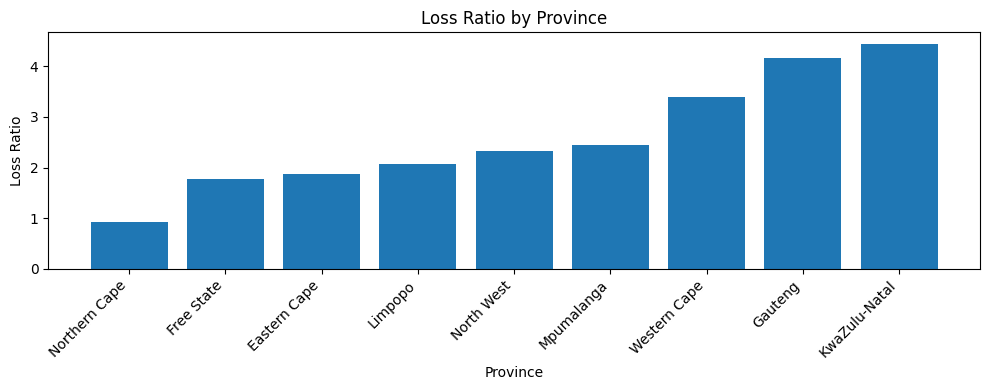

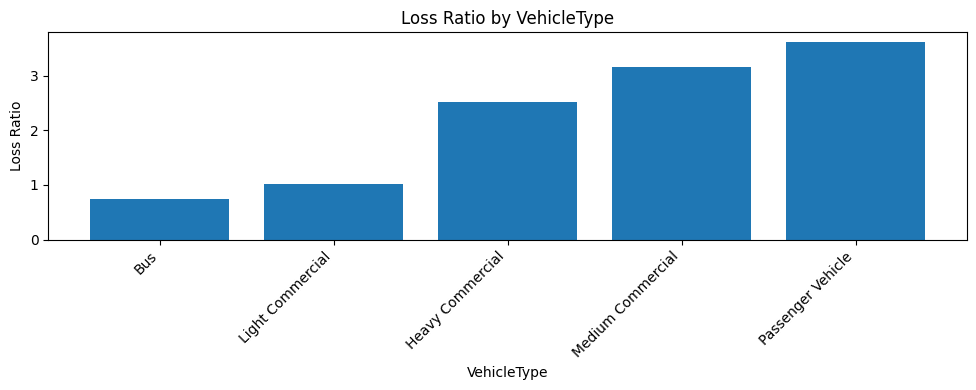

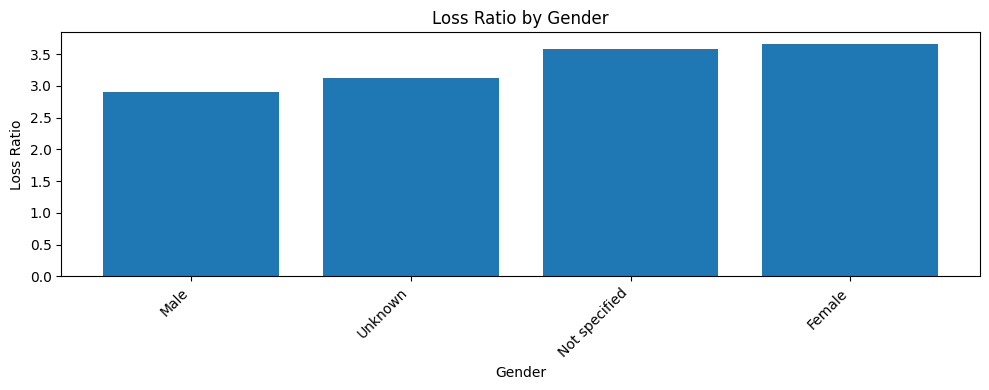

In [8]:
# Overall Loss Ratio & Variation
print(f"Portfolio Loss Ratio: {loss_ratio(df_clean):.2%}\n")

for col in ["Province", "VehicleType", "Gender"]:
    plot_loss_ratio(df_clean, col)

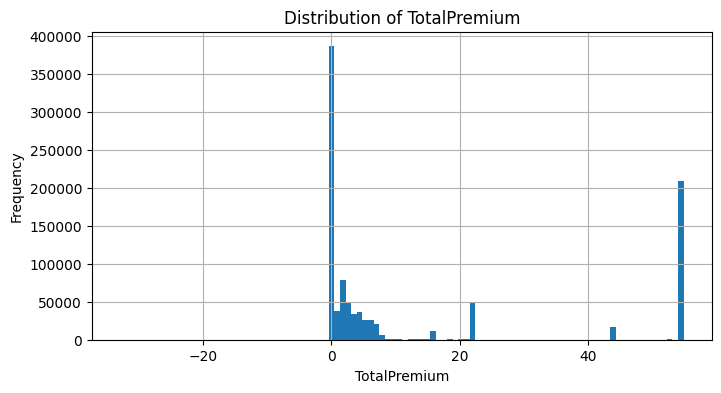

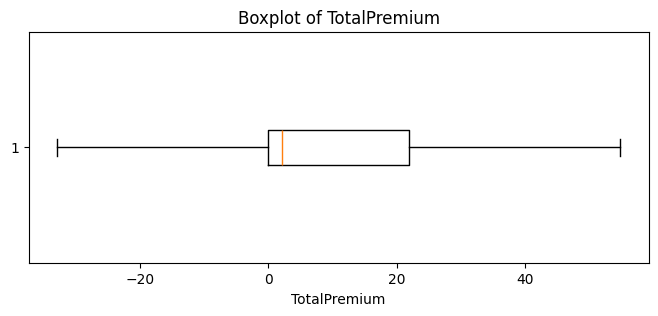

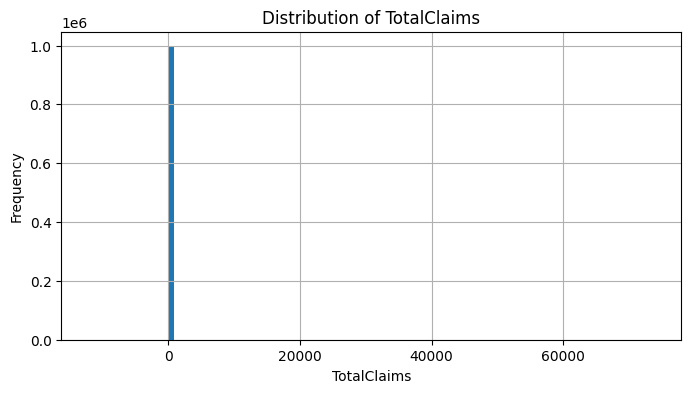

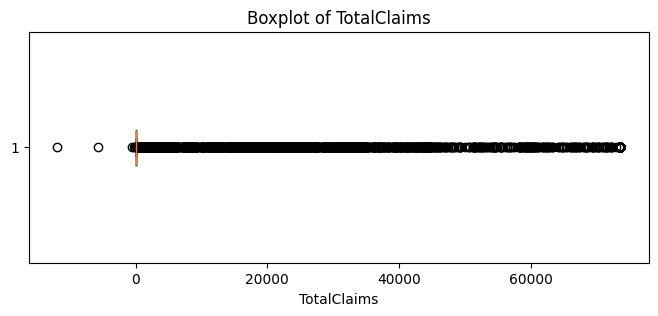

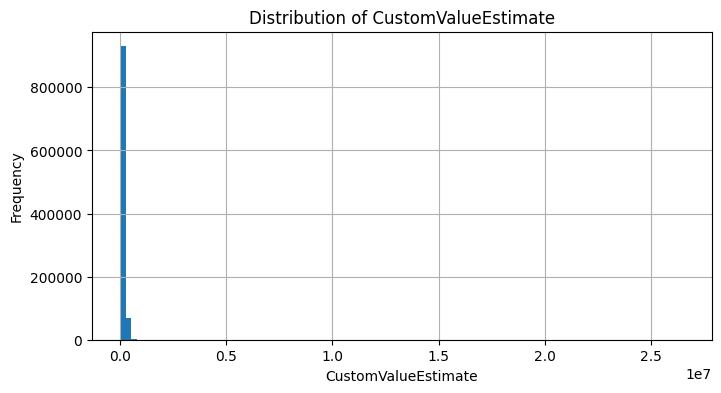

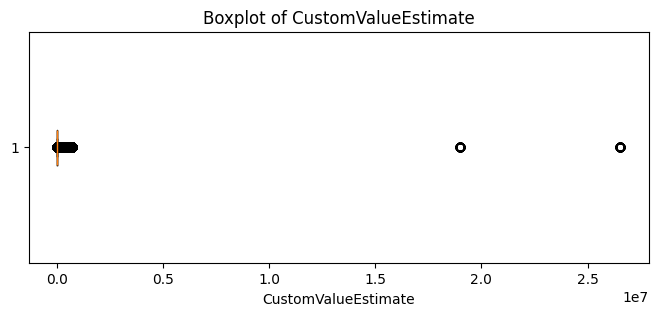

In [10]:
# Distributions & Outliers
for var in ["TotalPremium", "TotalClaims", "CustomValueEstimate"]:
    plot_histogram(df_clean, var, bins=100)
    plot_box(df_clean, var)

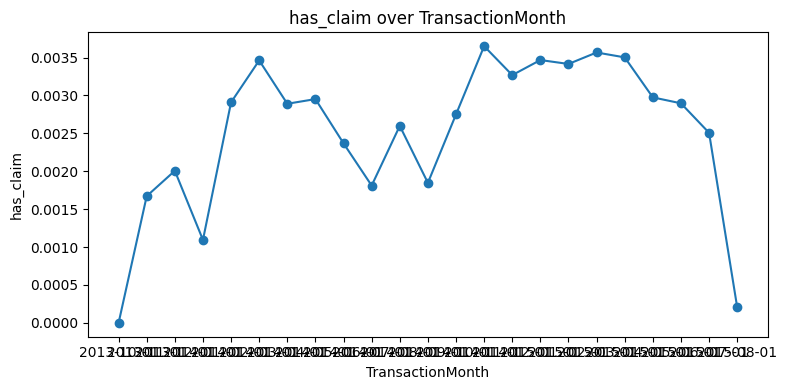

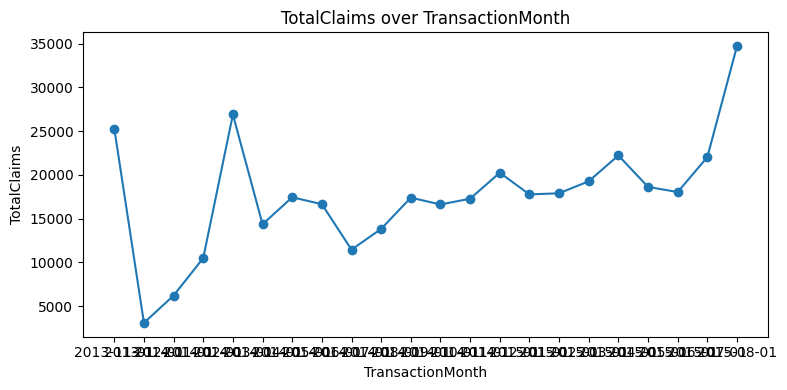

In [13]:
# Temporal Trends in Frequency & Severity
df_clean["has_claim"] = (df_clean.TotalClaims > 0).astype(int)

monthly_freq = (
    df_clean.groupby("TransactionMonth")["has_claim"]
      .mean()
      .reset_index()
)
plot_time_series(monthly_freq, "TransactionMonth", "has_claim")

monthly_sev = (
    df_clean[df_clean.TotalClaims > 0]
      .groupby("TransactionMonth")["TotalClaims"]
      .mean()
      .reset_index()
)
plot_time_series(monthly_sev, "TransactionMonth", "TotalClaims")

In [15]:
# Top/Bottom Vehicle Makes & Models by Avg Claim
make_stats = (
    df_clean.groupby("make")["TotalClaims"]
      .agg(["mean","count"])
      .reset_index()
      .query("count >= 100")
      .sort_values("mean")
)
print("Lowest 10 Makes by Avg Claim:")
display(make_stats.head(10))
print("\nHighest 10 Makes by Avg Claim:")
display(make_stats.tail(10))

model_stats = (
    df_clean.groupby("Model")["TotalClaims"]
      .agg(["mean","count"])
      .reset_index()
      .query("count >= 100")
      .sort_values("mean")
)
print("\nLowest 10 Models by Avg Claim:")
display(model_stats.head(10))
print("\nHighest 10 Models by Avg Claim:")
display(model_stats.tail(10))

Lowest 10 Makes by Avg Claim:


,make,mean,count
6,CITROEN,0.0,561
4,CHERY,0.0,361
16,HONDA,0.0,130
11,FORD,0.0,242
13,GEELY,0.0,108
15,HINO,0.0,242
23,KIA,0.0,244
17,HUMMER,0.0,1194
34,PEUGEOT,0.0,463
24,LEXUS,0.0,336



Highest 10 Makes by Avg Claim:


,make,mean,count
44,VOLKSWAGEN,59.150646,20929
14,GOLDEN JOURNEY,62.142117,14462
1,B.A.W,69.037433,2160
35,POLARSUN,78.858574,934
9,FIAT,81.390364,984
2,BMW,82.664581,5317
18,HYUNDAI,96.788051,2602
0,AUDI,106.336260,7407
22,JMC,191.684795,120
40,SUZUKI,340.071111,408



Lowest 10 Models by Avg Claim:


,Model,mean,count
100,C200K CLASSIC A/T,-0.250832,1022
0,0305 M BAR B/S CCL,0.000000,216
3,1400 CHAMP (B01) P/U S/C,0.000000,401
2,13-206 F/C C/C,0.000000,242
24,35 S13V 9M F/C P/V,0.000000,360
18,323 130 STING,0.000000,120
17,320i START (E90),0.000000,108
33,50 C13V 15M F/C P/V,0.000000,319
27,35S12V8 F/C P/V,0.000000,372
59,ALMERA 1.6 COMFORT (H01),0.000000,250



Highest 10 Models by Avg Claim:


,Model,mean,count
162,CRAFTER 50 2.0 BiTDi HR120KW XLWB F/C P/V,299.645585,653
187,ETIOS 1.5 Xs 5Dr,319.823861,332
177,E 200K,325.275910,227
12,320d START (E90),329.956303,108
275,POLO 1.6 COMFORTLINE,346.325658,236
358,SPRINTER 519 CDi XL F/C P/V,357.142028,136
396,VERSO 180 SX,361.289143,159
58,ALMERA 1.5 ACENTA,407.491681,300
182,ERTIGA 1.4 GA,511.988978,271
203,H-1 2.5 CRDI WAGON A/T,2252.760396,108


<ipython-input-16-3386742024>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  province_lr = df_clean.groupby("Province").apply(lambda x: x.TotalClaims.sum()/x.TotalPremium.sum())


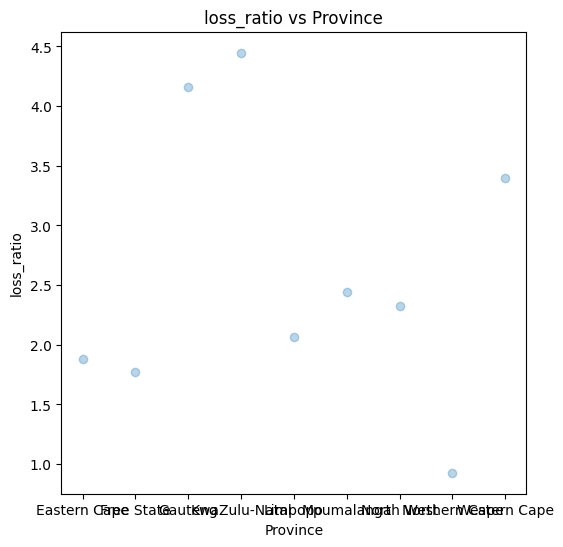

In [16]:
# Bivariate: Loss ratio by Province
province_lr = df_clean.groupby("Province").apply(lambda x: x.TotalClaims.sum()/x.TotalPremium.sum())
province_lr = province_lr.reset_index(name="loss_ratio")
plot_scatter(province_lr, "Province", "loss_ratio")

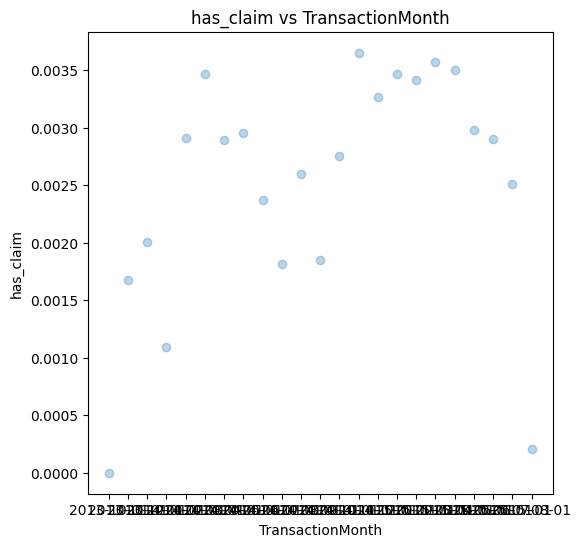

In [18]:
# Temporal trend of Claim Frequency
df_clean["has_claim"] = (df_clean.TotalClaims > 0).astype(int)
monthly = df_clean.groupby("TransactionMonth")["has_claim"].mean().reset_index()
plot_scatter(monthly, "TransactionMonth", "has_claim")